In [2]:
# helper function to plot the image with no axis and custom title
def plot(image, title="title", savefig=False):
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    if savefig == True:
        # convert image to RGB, then write
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite("output/" + title + ".png", image)

# Problem 1: k-means Segmentation (40 points)

In [3]:
# helper function
# get euclidean distance of RGB values
def dist_rgb(r1,g1,b1,r2,g2,b2):
    R = float(r1) - float(r2)
    G = float(g1) - float(g2)
    B = float(b1) - float(b2)
    
    return np.sqrt(R**2 + G**2 + B**2)

In [4]:
def KMeans(image, k=10, converged=False):
    # create copy of image to hold output
    out_img = image.copy()

    # initialize centroids
    initial_centroids = []

    while len(initial_centroids) < k:
        # randomly initialize centroids
        x = np.random.randint(0, image.shape[1] - 1)
        y = np.random.randint(0, image.shape[0] - 1)
        
        # duplication check
        if [x, y, image[y][x][2], image[y][x][1], image[y][x][0]] in initial_centroids:
            continue
        
        # add centroids to the list
        initial_centroids.append([x, y, image[y][x][2], image[y][x][1], image[y][x][0]])

    # list to hold the clusters
    clusters = []
    while(converged == False):
        # store clusters in this
        # pass it to the global cluster
        clusters = []

        # add empty lists to the clusters
        for _ in range(k):
            clusters.append([])

        # loop over entire image
        # find the distance of each pixel to the centroid
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                # initialize idx to zero
                # stores the index of the point with minimum distance
                idx = 0
                # set minimum distance to infinity
                dist_min = float('inf')

                # loop through every centroid
                for i in range(k):
                    # get the centroid's RGB value
                    r_cent = initial_centroids[i][2]
                    g_cent = initial_centroids[i][3]
                    b_cent = initial_centroids[i][4]
                    
                    # get pixel's RGB value
                    r_px = image[row][col][2]
                    g_px = image[row][col][1]
                    b_px = image[row][col][0]

                    # calculate distance
                    dist_curr = dist_rgb(r_px, g_px, b_px, r_cent, g_cent, b_cent)

                    # condition to check if the pixel selected has less distance
                    # than the current minimum distance
                    if dist_curr < dist_min:
                        idx = i
                        dist_min = dist_curr

                # once found, add the pixel to the cluster
                clusters[idx].append([col, row, image[row][col][2], image[row][col][1], image[row][col][0]])

        # centroid update
        # loop through each cluster
        for i in range(k):
            current_cluster = clusters[i]

            # calculate pixel value average
            # initialize RGB sum to zero
            r_sum = 0
            g_sum = 0
            b_sum = 0

            for j in range(len(current_cluster)):
                r_sum += current_cluster[j][2]
                g_sum += current_cluster[j][3]
                b_sum += current_cluster[j][4]

            r_avg = int(r_sum/len(current_cluster))
            g_avg = int(g_sum/len(current_cluster))
            b_avg = int(b_sum/len(current_cluster))

            # condition to check if the clusters have shifted
            # if not, we have reached convergence
            if r_avg != initial_centroids[i][2] or g_avg != initial_centroids[i][3] or b_avg != initial_centroids[i][4]:
                initial_centroids[i][2] = r_avg
                initial_centroids[i][3] = g_avg
                initial_centroids[i][4] = b_avg
            else:
                converged = True
    
    # loop through the centroids and update out_img
    # with the clusters
    for x in range(k):
        cluster_avg = initial_centroids[x]
        cluster_curr = clusters[x]

        for pt in cluster_curr:
            out_img[pt[1]][pt[0]][2] = cluster_avg[2]
            out_img[pt[1]][pt[0]][1] = cluster_avg[3]
            out_img[pt[1]][pt[0]][0] = cluster_avg[4]

    return out_img

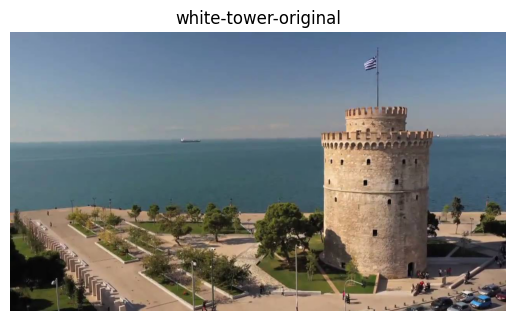

In [5]:
white_tower = cv2.imread("white-tower.png")
white_tower = cv2.cvtColor(white_tower, cv2.COLOR_BGR2RGB)
plot(white_tower, title="white-tower-original", savefig=False)

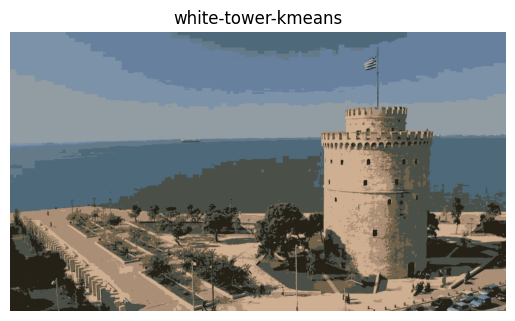

In [6]:
white_tower_after_kmeans = KMeans(white_tower, k=10, converged=False)
plot(white_tower_after_kmeans, title="white-tower-kmeans", savefig=True)

# Problem 2: SLIC (40 points)

In [7]:
# helper function
# get euclidean distance of RGBXY values
def dist_rgbxy(x1, y1, r1, g1, b1, x2, y2, r2, g2, b2):
    R = (float(r1)-float(r2))
    G = (float(g1)-float(g2))
    B = (float(b1)-float(b2))
    X = (float(x1)-float(x2))
    Y = (float(y1)-float(y2))
    
    return np.sqrt(R**2 + G**2 + B**2 + (X**2)/2 + (Y**2)/2)

In [8]:
# K-means for SLIC
# similar to the previous K-means segmentation
# but here, instead of randomly choosing the centroids
# we take the points from the SLIC block size center

def KMeans_SLIC(image, points, max_iters=3, converged=False):
    # create copy of image to hold output
    out_img = image.copy()
    # initialize centroids
    centroids = []

    # add each point obtained using the block size
    # to the centroids
    for pt in range(len(points)):
        x = points[pt][1]
        y = points[pt][0]
        centroids.append([x, y, image[y][x][2], image[y][x][1], image[y][x][0]])

    # counter to count the number of iterations
    # according to the question, max_iters = 3
    current_iter = 0

    while converged == False and current_iter < max_iters:
        # increment iteration
        current_iter += 1

        # same as before, create a cluster list which will
        # store the clusters
        clusters = []
        for i in range(len(points)):
            clusters.append([])

        # loop through entire image, find the pixels that has least
        # distance with the centroids
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                # initialize idx to zero
                # stores the index of the point with minimum distance
                idx = 0
                # set minimum distance to infinity
                dist_min = float('inf')

                # loop through all the centroids and calculate distance
                for i in range(len(points)):
                    pixel_curr = centroids[i]

                    # RGB values of current pixel (centroid)
                    r_curr = pixel_curr[2]
                    g_curr = pixel_curr[3]
                    b_curr = pixel_curr[4]

                    # RGB value of the current pixel in image
                    r_px = image[row][col][2]
                    g_px = image[row][col][1]
                    b_px = image[row][col][0]

                    # condition to check the difference between pixel intensities
                    # if condition applied to stabalize the algorithm
                    # to check only those pixels within 100 pixels from the centroid
                    # if outside 100 pixels, continue
                    # else compute distance
                    if np.sqrt((float(pixel_curr[0]) - float(col))**2 + (float(pixel_curr[1]) - float(row))**2) > 100:
                        continue
                    else:
                        dist_curr = dist_rgbxy(pixel_curr[0], pixel_curr[1], r_px, g_px, b_px, col, row, r_curr, g_curr, b_curr)
                        
                        # check current distance with the current minimum distance
                        if dist_curr < dist_min:
                            idx = i
                            dist_min = dist_curr
                
                # add the pixel to the clusters if it has minimum distance
                clusters[idx].append([col, row, image[row][col][2], image[row][col][1], image[row][col][0]])

        # centroid update
        # loop through each cluster
        for i in range(len(points)):
            current_cluster = clusters[i]

            # calculate pixel value average
            # initialize RGB sum to zero
            r_sum = 0
            g_sum = 0
            b_sum = 0

            for j in range(len(current_cluster)):
                r_sum += current_cluster[j][2]
                g_sum += current_cluster[j][3]
                b_sum += current_cluster[j][4]

            r_avg = int(r_sum/len(current_cluster))
            g_avg = int(g_sum/len(current_cluster))
            b_avg = int(b_sum/len(current_cluster))

            # condition to check if clusters have shifted
            # if not, we have reached convergence
            if r_avg != centroids[i][2] or g_avg != centroids[i][3] or b_avg != centroids[i][4]:
                centroids[i][2] = r_avg
                centroids[i][3] = g_avg
                centroids[i][4] = b_avg
            else:
                converged = True

    # loop to add the SLIC image (segmented) to the out_img
    for x in range(len(points)):
        c = clusters[x]

        for point in c:
            out_img[point[1]][point[0]][2] = centroids[x][2]
            out_img[point[1]][point[0]][1] = centroids[x][3]
            out_img[point[1]][point[0]][0] = centroids[x][4]

    return out_img

In [9]:
# SLIC function
# takes in image and block size

def SLIC(image, block=50):

    # initialize centroids, calculate the middle of the block
    # to get the centroids
    centroids = []
    mid = block / 2
    
    # best points refer to the middle point of the block
    best_points = [0, 0]
    
    # loop through each image
    # check for the center pixel
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if row != 0 and col != 0 and ((row - mid) % block) == 0 and ((col - mid) % block) == 0:
                centroids.append([row,col])

    # once we get the centroids, we move the centroids with the smallest gradient (del)
    for centroid in range(len(centroids)):
        # initially, minimum gradient set to infinity
        del_min = float('inf')
        
        # get x and y coordinates of the centroids
        x = centroids[centroid][1]
        y = centroids[centroid][0]

        # loop to move the centroids to the smallest gradient within a 3x3 area
        for i in range(-1, 1):
            for j in range(-1, 1):
                del_curr = np.sqrt(float(int(image[y+i+1][x+j+1][0]) - int(image[y+i][x+j][0]))**2 + 
                                float(int(image[y+i+1][x+j+1][1]) - int(image[y+i][x+j][1]))**2 + 
                                float(int(image[y+i+1][x+j+1][2]) - int(image[y+i][x+j][2]))**2)
                # condition to check if we found a minimum gradient
                if del_curr < del_min:
                    del_min = del_curr
                    # add the point with minimum gradient to the best points
                    best_points = [y+i, x+j]
        
        # update the centroids
        # these will be our starting points for the K-means for SLIC
        centroids[centroid] = best_points
    
    return KMeans_SLIC(image, centroids, max_iters=3, converged=False)

In [10]:
# function to add black borders to the segmented image

def add_borders_to_slic(image):
    # create a copy
    image_with_borders = image.copy()
    # variable that stores the color of the border (black)
    black_border = [0, 0, 0]
    
    # loop through each image
    # we want those pixels who have different colors to create a black border
    for row in range(image.shape[0] - 1):
        for col in range(image.shape[1] - 1):
            # edge case
            if row == 0 or col == 0:
                continue
            else:
                for i in range(-1, 1):
                    for j in range(-1, 1):
                        if ((image[row][col][0] == image[row+i][col+j][0]) and 
                            (image[row][col][1] == image[row+i][col+j][1]) and 
                            (image[row][col][2] == image[row+i][col+j][2])):
                            continue
                        else:
                            image_with_borders[row][col] = black_border

    return image_with_borders

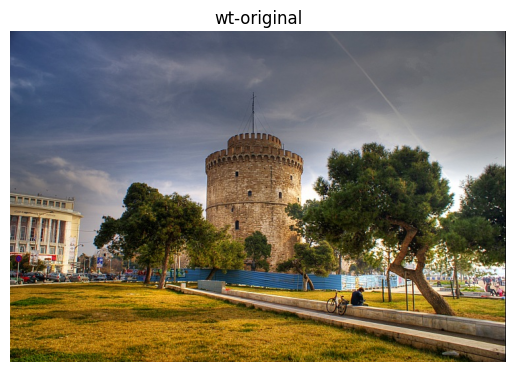

In [11]:
wt = cv2.imread("wt_slic.png")
wt = cv2.cvtColor(wt, cv2.COLOR_BGR2RGB)
plot(wt, title="wt-original", savefig=False)

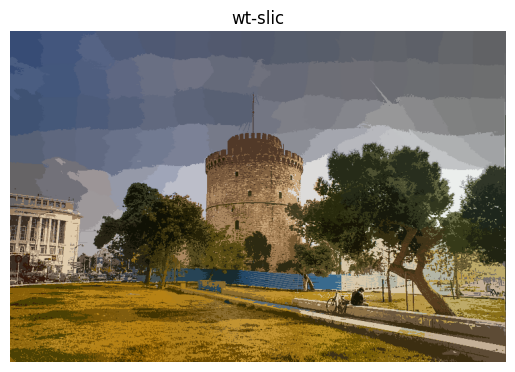

In [12]:
wt_slic = SLIC(wt, 50)
plot(wt_slic, title="wt-slic", savefig=True)

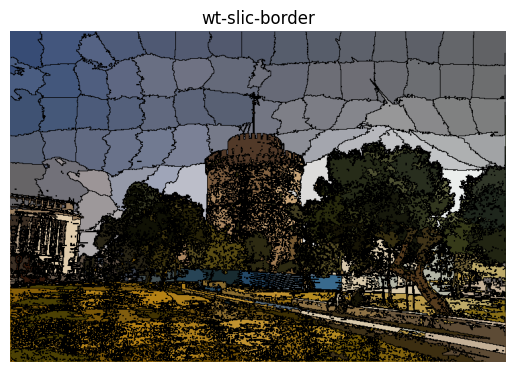

In [13]:
wt_slic_border = add_borders_to_slic(wt_slic)
plot(wt_slic_border, title="wt-slic-border", savefig=True)

# Problem 3: Pixel Classification (40 points)

In [14]:
# K-means function for pixel classification
# similar to the other two, but here we take the starting points
# obtained from sky.jpg and sky_train.jpg

def KMeans_sky(points, k=10, converged=False):
    # initialize centroids and clusters
    initial_centroids = []
    clusters = []
    
    # loop to add starting points to the centroids
    while len(initial_centroids) < k:
        x = np.random.randint(0, len(points) - 1)

        if [points[x][0], points[x][1], points[x][2]] in initial_centroids:
            continue
        else:
            initial_centroids.append([points[x][0], points[x][1], points[x][2]])
    
    # loop to find distinction between sky and non-sky
    while(converged == False):
        clusters = []
        
        # add empty list to the clusters
        for _ in range(k):
            clusters.append([])
        
        # loop through each starting point and calculate the distance
        # between centroid and pixels
        for i in range(len(points)):
            # idx stores the index of the pixel with least distance
            idx = 0
            # set minimum distance to infinity initially
            dist_min = float('inf')
            
            # loop through the clusters and get the RGB values
            # of the current pixel and the centroid
            for j in range(len(clusters)):
                # RGB value of points
                r_px = points[i][0]
                g_px = points[i][1]
                b_px = points[i][2]
                
                # RGB values of the centroids
                r_cent = initial_centroids[j][0]
                g_cent = initial_centroids[j][1]
                b_cent = initial_centroids[j][2]
                
                # calculate the RGB distance between the pixels
                dist_curr = dist_rgb(r_cent, g_cent, b_cent, r_px, g_px, b_px)
                
                # condition to check the current distance 
                # with the previous minimum distance
                if dist_curr < dist_min:
                    idx = j
                    dist_min = dist_curr
            
            # add the point with the minimum distance to the cluster
            clusters[idx].append([points[i][0], points[i][1], points[i][2]])
        
        # centroid and convergence check
        for i in range(k):
            current_cluster = clusters[i]

            if len(current_cluster) == 0:
                continue
            # calculate pixel value average
            r_sum = 0
            g_sum = 0
            b_sum = 0

            for j in range(len(current_cluster)):
                r_sum += current_cluster[j][0]
                g_sum += current_cluster[j][1]
                b_sum += current_cluster[j][2]

            r_avg = int(r_sum/len(current_cluster))
            g_avg = int(g_sum/len(current_cluster))
            b_avg = int(b_sum/len(current_cluster))
            
            # condition to check if clusters have shifted
            # if not, we have reached convergence
            if r_avg != initial_centroids[i][0] or g_avg != initial_centroids[i][1] or b_avg != initial_centroids[i][2]:
                initial_centroids[i][0] = r_avg
                initial_centroids[i][1] = g_avg
                initial_centroids[i][2] = b_avg
            else:
                converged = True
    
    # return the centroids, they will be used as starting points for sky detection
    return initial_centroids

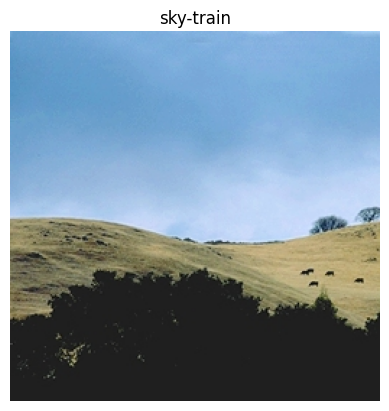

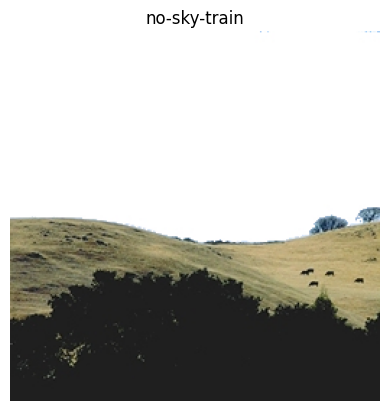

In [15]:
sky = cv2.imread("sky/sky_train.jpg")
sky = cv2.cvtColor(sky, cv2.COLOR_BGR2RGB)
plot(sky, title="sky-train", savefig=False)

sky_train = cv2.imread("sky/no_sky_train.jpg")
sky_train = cv2.cvtColor(sky_train, cv2.COLOR_BGR2RGB)
plot(sky_train, title="no-sky-train", savefig=False)

In [16]:
# initialize all the test images into a list
sky_test = ["sky/sky_test1.jpg",
            "sky/sky_test2.jpg",
            "sky/sky_test3.jpg",
            "sky/sky_test4.jpg"]

# initialize sky and sky_train points
# pixels that contain sky or not
sky_pts = []
sky_train_pts = []
sky_color = sky_train[0][0]

# set final color of detected sky to red
final_color = [255, 0, 0]

In [17]:
# loop through sky_train, get the value of the current pixel
# if the pixel corresponds to sky, add to list sky
# else, add to sky_train

for row in range(sky_train.shape[0]):
    for col in range(sky_train.shape[1]):
        if (sky_train[row][col][0] == sky_color[0] and 
            sky_train[row][col][1] == sky_color[1] and 
            sky_train[row][col][2] == sky_color[2]):
            sky_pts.append([sky[row][col][2], sky[row][col][1], sky[row][col][0]])
        else:
            sky_train_pts.append([sky_train[row][col][2], sky_train[row][col][1], sky_train[row][col][0]])

In [18]:
# get clusters from the original sky image and sky_train

sky_clusters = KMeans_sky(sky_pts, 10, converged=False)
#print(sky_clusters)
sky_train_clusters = KMeans_sky(sky_train_pts, 10, converged=False)
#print(sky_train_clusters)

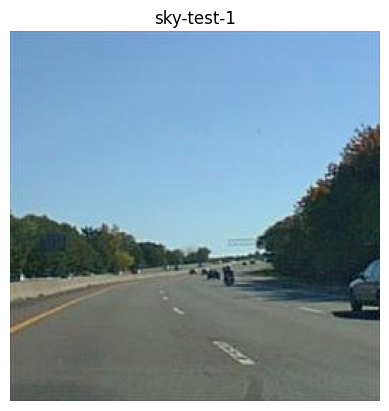

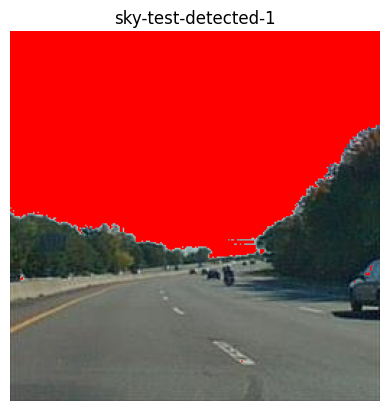

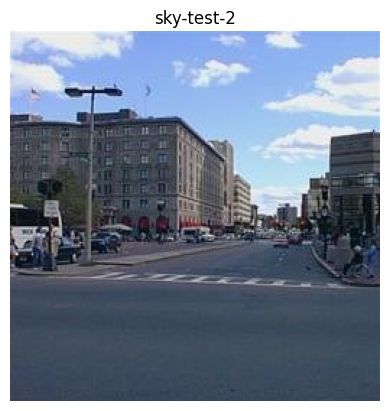

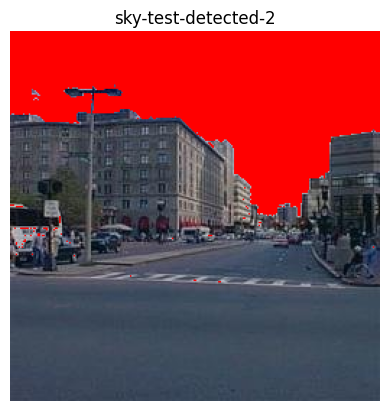

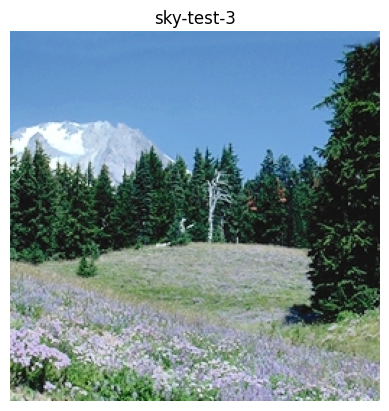

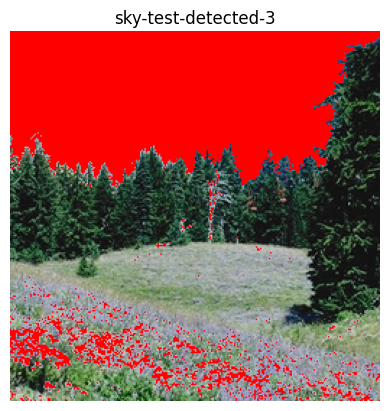

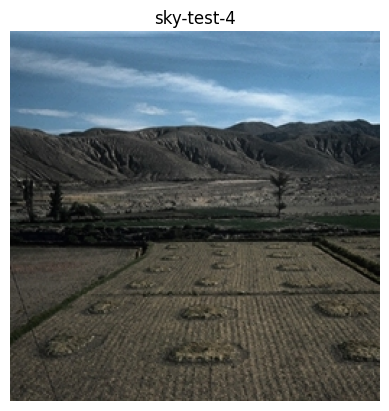

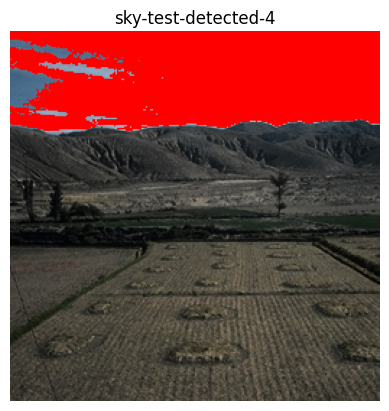

In [19]:
# counter to add the output image to the output folder
# also for adding title for sky-test
count = 1

# loop through each test image
for file in sky_test:
    sky_curr = cv2.imread(file)
    sky_curr = cv2.cvtColor(sky_curr, cv2.COLOR_BGR2RGB)
    
    title1 = "sky-test-" + str(count)
    
    # plot the test image and create a copy
    plot(sky_curr, title=title1, savefig=False)
    out_img = sky_curr.copy()

    # loop through current test image
    for row in range(sky_curr.shape[0]):
        for col in range(sky_curr.shape[1]):

            # get current RGB values of the pixels
            # from the test image
            R = sky_curr[row][col][2]
            G = sky_curr[row][col][1]
            B = sky_curr[row][col][0]

            # initialize minimum distance to infinity
            dist_min = float('inf')

            # loop to find the minimum distance between the test image pixels and the sky_train clusters
            for c in range(len(sky_train_clusters)):
                # calculate current distance
                dist_sky_train = dist_rgb(R, G, B, sky_train_clusters[c][0], sky_train_clusters[c][1], sky_train_clusters[c][2])

                # update the minimum distance if smaller
                if dist_sky_train < dist_min:
                    dist_min = dist_sky_train

            # loop to find minimum distance between the test image pixels and sky clusters
            for c in range(len(sky_clusters)):
                # calculate current distance
                dist_sky = dist_rgb(R, G, B, sky_clusters[c][0], sky_clusters[c][1], sky_clusters[c][2])

                # update the minimul distance if smaller
                if dist_sky < dist_min:
                    # color the test image sky to red for distinction
                    # and break out of the loop
                    out_img[row][col] = final_color
                    break
    
    # plot the test image with sky detected and save the image
    title2 = "sky-test-detected-" + str(count)
    plot(out_img, title=title2, savefig=True)
    
    # increment count for next image
    count += 1